# GMNmeteorNet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
import math
import pickle
import keras_tuner as kt
import random

%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

In [2]:
datasets_folder = "datasets"
dataset_name = "CNN_n10000_p20_random"

Number of images: 10008
Median: 78.0
Last non-outlier dimension: 180


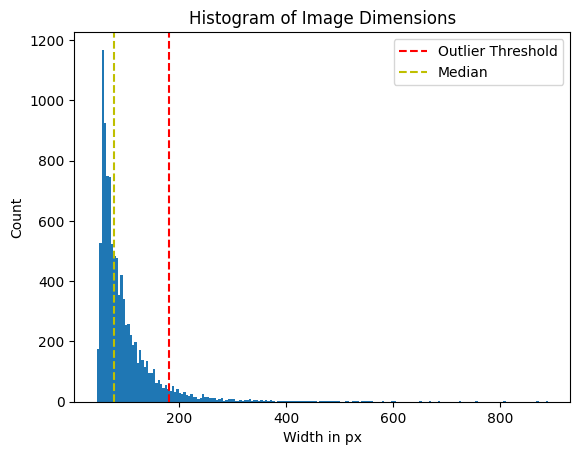

In [3]:
dataset = os.path.join(datasets_folder, dataset_name)
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):
        img = os.path.join(i, j)
        img = Image.open(img)
        img_array = np.array(img)
        dimensions.append(img_array.shape[0])

print("Number of images:", len(dimensions))
median = np.median(dimensions)
print("Median:", median)

# inertquartile range method for calculating outliers
q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[
    0
]
last_non_outlier = dimensions[first_outlier[0] - 1]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])

plt.hist(dimensions, bins="auto")
plt.axvline(
    x=dimensions[first_outlier[0] - 1],
    color="r",
    linestyle="--",
    label="Outlier Threshold",
)
plt.axvline(x=median, color="y", linestyle="--", label="Median")
plt.legend()
plt.xlabel("Width in px")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

## Image augmentation


In [149]:
confirmed_num = 0
for filename in os.listdir(dirs[0]):
    if "augmented" in filename:
        confirmed_num += len(os.listdir(os.path.join(dirs[0], filename)))
        
    else:
        confirmed_num += 1

print("Number of meteor images:", confirmed_num)


rejected_num = 0
for filename in os.listdir(dirs[1]):
    if "augmented" in filename:
        rejected_num += len(os.listdir(os.path.join(dirs[1], filename)))
        
    else:
        rejected_num += 1

print("Number of artifact images:", rejected_num)

Number of meteor images: 5000
Number of artifact images: 5000


In [150]:
augment = tf.keras.Sequential(
    [layers.RandomRotation((1/6-1/24,1/6+1/24),fill_mode="constant"), 
     #layers.RandomZoom((-0.5, 0.25),fill_mode="constant")
     ]
)
coeff = 0.2

filtered_files = [file for file in  os.listdir(dirs[0]) if "augmented" not in file]
random.shuffle(filtered_files)
os.makedirs(os.path.join(dirs[1], "augmented"), exist_ok=True)

def augment_image(dir_path,img_num):
    for i in range(coeff*img_num):
        random_image = filtered_files[i]
        random_image_path = os.path.join(dir_path, random_image)

        img = Image.open(random_image_path)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=-1)

        img_array = augment(img_array)

        augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
        
        # Save the image
        base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
        full_path = os.path.join(dir_path, "augmented", base_filename + ".png")

        augmented_img.save(full_path)
        img_num += 1
    return img_num
meteor_num=augment_image(dirs[0],confirmed_num)
artifact_num=augment_image(dirs[1],rejected_num)


print("Number of meteor images:", meteor_num)
print("Number of artifact images:", artifact_num)

TypeError: 'float' object cannot be interpreted as an integer

## Dataset

### Dataset creation


In [4]:
IMG_SIZE = int(median)  # seems about right
# IMG_SIZE = dimensions[first_outlier[0] - 1]
# IMG_SIZE = 32
BATCH_SIZE = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 10008 files belonging to 2 classes.
Using 8007 files for training.
Using 2001 files for validation.


### Dataset normalization


In [5]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    # image = tf.image.per_image_standardization(image) # model performs a bit worse with this on, values are not in 0 to 1 range

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

augment = tf.keras.Sequential(
    [layers.RandomRotation((1/6-1/24,1/6+1/24),fill_mode="constant"), 
     #layers.RandomZoom((-0.5, 0.25),fill_mode="constant")
     ]
)
"""
train_ds = train_ds.map(
  lambda x, y: (augment(x, training=True), y))
val_ds = val_ds.map(
  lambda x, y: (augment(x, training=True), y))
"""
# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Dataset visualization

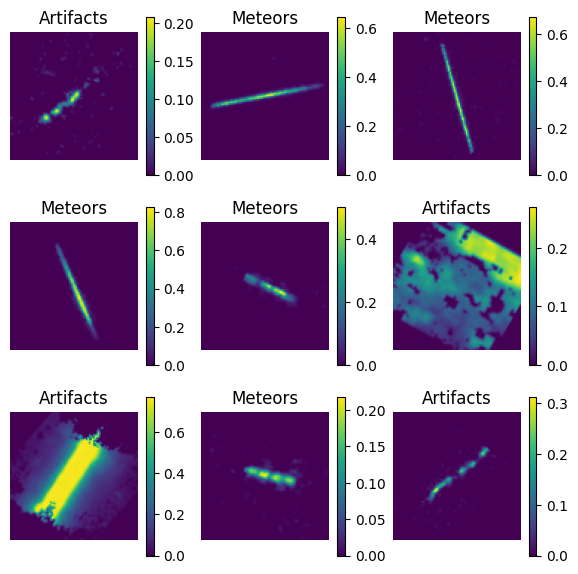

In [20]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

## Model


In [6]:
global_metrics = [
    tf.keras.metrics.Recall(name="recall", thresholds=0.5),
    tf.keras.metrics.Precision(name="precision", thresholds=0.5),
    # prioritize recall over precision
    tf.keras.metrics.FBetaScore(name="fbeta2", beta=2.0, threshold=0.5),
]

### Hypermodel

In [54]:
# initial model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133


def model_builder(hp):
    model = tf.keras.models.Sequential()

    #img_size = hp.Choice("img_size", [32, int(median), int(last_non_outlier)])
    # model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(layers.Resizing(IMG_SIZE, IMG_SIZE, input_shape=(None, None, 1)))

    if hp.Boolean("normalize"):
        model.add(layers.Normalization())
    for i in range(hp.Int("num_conv_layers", 1, 3)):

        model.add(
            layers.Conv2D(
                hp.Int(
                    f"conv_filter_num_{i}",
                    min_value=5 + 3 * i,
                    max_value=15 + 5 * i,
                    step=2,
                ),
                hp.Int(f"conv_kernel_{i}", 3, 10),
                strides=hp.Int(f"conv_stride_{i}", 1, 3),
                activation="relu",
            )
        )
        if hp.Boolean(f"maxpool_{i}"):
            model.add(
                layers.MaxPooling2D(
                    hp.Int(f"max_kernel_size_{i}", 2, 6),
                    strides=hp.Int(f"max_stride_{i}", 1, 2),
                )
            )

    model.add(layers.Flatten())

    if hp.Boolean("2nd_dense"):
        model.add(
            layers.Dense(
                units=hp.Choice("dense_units", values=[16, 32, 64]),
                activation="relu",
            )
        )
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss=(losses.BinaryCrossentropy()),
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4])
        ),
        metrics=global_metrics,
    )

    return model

### Tuning

In [55]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_fbeta2", direction="max"),
    max_epochs=22,
    factor=3,
    directory="keras_tuner",
    project_name="GMNmeteorNet",
    overwrite=True,
    hyperband_iterations=1,
)
# tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

In [56]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./tb_logs")],
)

Trial 28 Complete [00h 01m 16s]
val_fbeta2: 0.9632997512817383

Best val_fbeta2 So Far: 0.9702990055084229
Total elapsed time: 00h 15m 04s


In [57]:
tuner.results_summary()

Results summary
Results in keras_tuner/GMNmeteorNet
Showing 10 best trials
Objective(name="val_fbeta2", direction="max")

Trial 0012 summary
Hyperparameters:
normalize: True
num_conv_layers: 3
conv_filter_num_0: 9
conv_kernel_0: 3
conv_stride_0: 1
maxpool_0: True
2nd_dense: False
learning_rate: 0.001
max_kernel_size_0: 6
max_stride_0: 2
conv_filter_num_1: 8
conv_kernel_1: 3
conv_stride_1: 1
maxpool_1: True
conv_filter_num_2: 15
conv_kernel_2: 3
conv_stride_2: 1
maxpool_2: True
max_kernel_size_1: 2
max_stride_1: 1
dense_units: 16
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
max_kernel_size_2: 2
max_stride_2: 1
tuner/trial_id: 0006
Score: 0.9702990055084229

Trial 0022 summary
Hyperparameters:
normalize: True
num_conv_layers: 2
conv_filter_num_0: 11
conv_kernel_0: 5
conv_stride_0: 3
maxpool_0: False
2nd_dense: True
learning_rate: 0.001
max_kernel_size_0: 3
max_stride_0: 2
conv_filter_num_1: 14
conv_kernel_1: 10
conv_stride_1: 2
maxpool_1: True
conv_filter_num_2:

In [58]:
best_hp = tuner.get_best_hyperparameters(num_trials=2)[0]
models_list = tuner.get_best_models(num_models=2)
for i in models_list:
    i.summary()

print(best_hp.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 86, 86, 1)         0         
                                                                 
 normalization (Normalizati  (None, 86, 86, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 84, 84, 9)         90        
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 9)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 8)         656       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 8)         0

In [ ]:
%load_ext tensorboard

%tensorboard --logdir ./tb_logs

In [59]:
# Get the optimal hyperparameters
model_name = "CNN_20240915_1"
model = tuner.hypermodel.build(best_hp)
# model=models_list[0]
model._name = model_name
model.summary()

Model: "CNN_20240915_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 86, 86, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 86, 86, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 9)         90        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 9)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 8)         656       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 8)      

In [60]:
# saving model architecture
json_config = model.to_json()
with open(f"models/configs/{model_name}_config.json", "w") as json_file:
    json_file.write(json_config)

### Model architecture loading

In [15]:
with open("models/configs/CNN_20240505_1_config.json", "r") as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)
model.compile(
    loss=(losses.BinaryCrossentropy()),
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=global_metrics,
)

model.summary()

Model: "CNN_20240505_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 87, 87, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 6)         60        
                                                                 
 dropout (Dropout)           (None, 85, 85, 6)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 13)        5005      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 13)          0         
 g2D)                                               

### Training

In [16]:
EPOCHS = 30

# this is to store model weights after each epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"temp/{model._name}/weights_epoch_{{epoch:02d}}.h5",
    save_weights_only=True,
    save_freq="epoch",
)
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint_callback]
)

Epoch 1/30
126/126 [==============================] - 7s 39ms/step - loss: 0.3553 - recall: 0.8542 - precision: 0.8952 - fbeta2: 0.8621 - val_loss: 0.1857 - val_recall: 0.9929 - val_precision: 0.9035 - val_fbeta2: 0.9737
Epoch 2/30
126/126 [==============================] - 1s 11ms/step - loss: 0.1714 - recall: 0.9910 - precision: 0.9119 - fbeta2: 0.9741 - val_loss: 0.1540 - val_recall: 0.9909 - val_precision: 0.9325 - val_fbeta2: 0.9787
Epoch 3/30
126/126 [==============================] - 1s 10ms/step - loss: 0.1594 - recall: 0.9893 - precision: 0.9217 - fbeta2: 0.9750 - val_loss: 0.1504 - val_recall: 0.9980 - val_precision: 0.9023 - val_fbeta2: 0.9773
Epoch 4/30
126/126 [==============================] - 2s 12ms/step - loss: 0.1493 - recall: 0.9898 - precision: 0.9258 - fbeta2: 0.9763 - val_loss: 0.1338 - val_recall: 0.9909 - val_precision: 0.9352 - val_fbeta2: 0.9792
Epoch 5/30
126/126 [==============================] - 1s 12ms/step - loss: 0.1415 - recall: 0.9883 - precision: 0.93

## Result analysis

### Plotting metrics

[0.9736529, 0.97865117, 0.9772503, 0.97923744, 0.9799245, 0.98301697, 0.98328024, 0.9817672, 0.9829999, 0.98357373, 0.978108, 0.9839519, 0.9744313, 0.9833267, 0.9847573, 0.987395, 0.9815335, 0.97987926, 0.98638093, 0.9792673, 0.9839357, 0.9839357, 0.9770346, 0.9851526, 0.9851526, 0.9863946, 0.9770577, 0.9845443, 0.97278225, 0.9865516]
Best Fbeta score of 0.987 at epoch 16


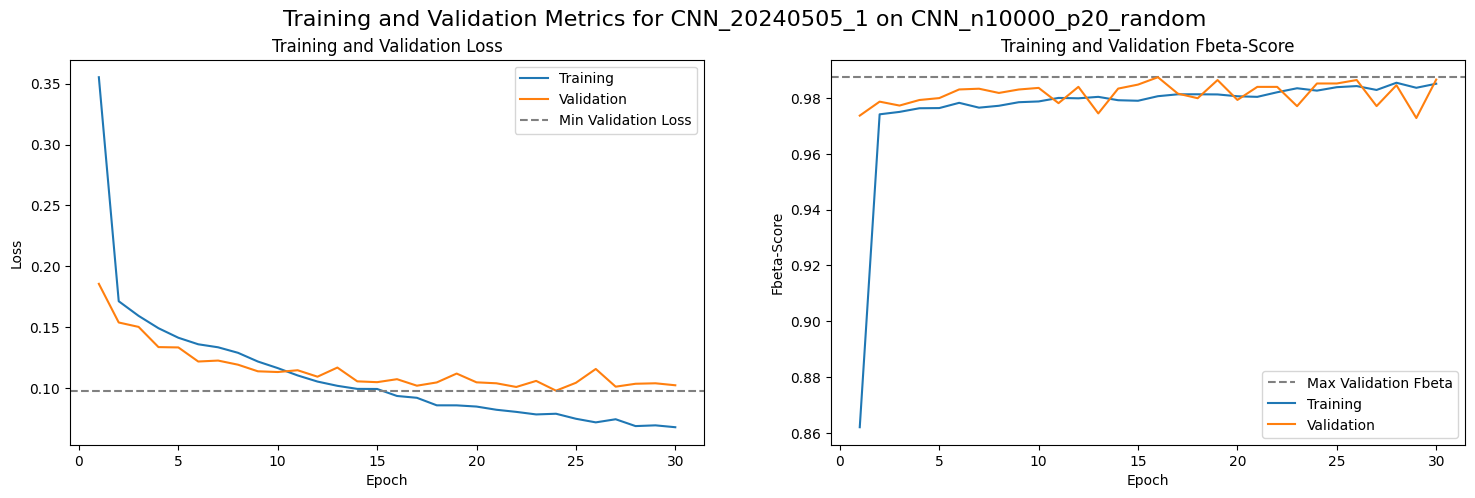

In [17]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
fbeta2 = history.history["fbeta2"]
val_fbeta2 = history.history["val_fbeta2"]

print([i[0] for i in val_fbeta2])
print(
    "Best Fbeta score of",
    round(max(val_fbeta2)[0], 3),
    "at epoch",
    val_fbeta2.index(max(val_fbeta2)) + 1,
)

epoch_range = range(1, len(loss) + 1)
plt.figure(figsize=(18, 5))
plt.suptitle(f"Training and Validation Metrics for {model._name} on {dataset_name}", fontsize=16)


# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.axhline(y=min(val_loss), color="grey", linestyle="--", label="Min Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Recall Plot
plt.subplot(1, 2, 2)
# plot horizontal line at max(val_beta2)
plt.axhline(
    y=max(val_fbeta2), color="grey", linestyle="--", label="Max Validation Fbeta"
)
plt.plot(epoch_range, fbeta2, label="Training")
plt.plot(epoch_range, val_fbeta2, label="Validation")
plt.title("Training and Validation Fbeta-Score")
plt.xlabel("Epoch")
plt.ylabel("Fbeta-Score")
plt.legend()

# plt.savefig(f"models/plots/CNN_n10000_p20_l10_random_median/{model._name}_results.png")
plt.show()

### Confusion matrix

In [18]:
# pick model state at a certain epoch
best_epoch = 16
model.load_weights(f"temp/{model._name}/weights_epoch_{best_epoch}.h5")

In [19]:
model.save(f"models/keras/{model._name}.keras")

In [21]:
Y_pred = model.predict(val_ds, verbose=0)
Y_pred_labels = np.squeeze(np.round(Y_pred))

Y_true = np.squeeze(np.concatenate([y for _, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_labels, num_classes=2).numpy()
print("True positives:", confusion_mtx[1][1])
print("True negatives:", confusion_mtx[0][0])
print("False positives:", confusion_mtx[0][1])
print("False negatives:", confusion_mtx[1][0])

precision = confusion_mtx[1][1] / (confusion_mtx[1][1] + confusion_mtx[0][1])
recall = confusion_mtx[1][1] / (confusion_mtx[1][1] + confusion_mtx[1][0])
print("\nPrecision:", precision)
print("Recall:", recall)
false_negatives = confusion_mtx[1][0]
false_positives = confusion_mtx[0][1]

f1 = 2 * precision * recall / (precision + recall)
print("\nF1-Score:", f1)
beta = 2
fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
print("Fbeta:", fbeta)

True positives: 987
True negatives: 960
False positives: 51
False negatives: 3

Precision: 0.9508670520231214
Recall: 0.996969696969697

F1-Score: 0.9733727810650887
Fbeta: 0.9873949579831933


### Mislabeled images

False negatives: 3
False positives: 51


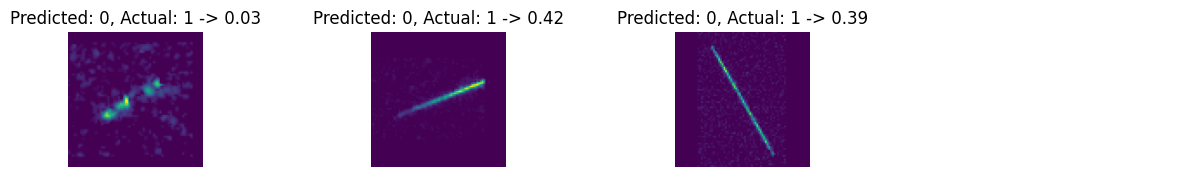

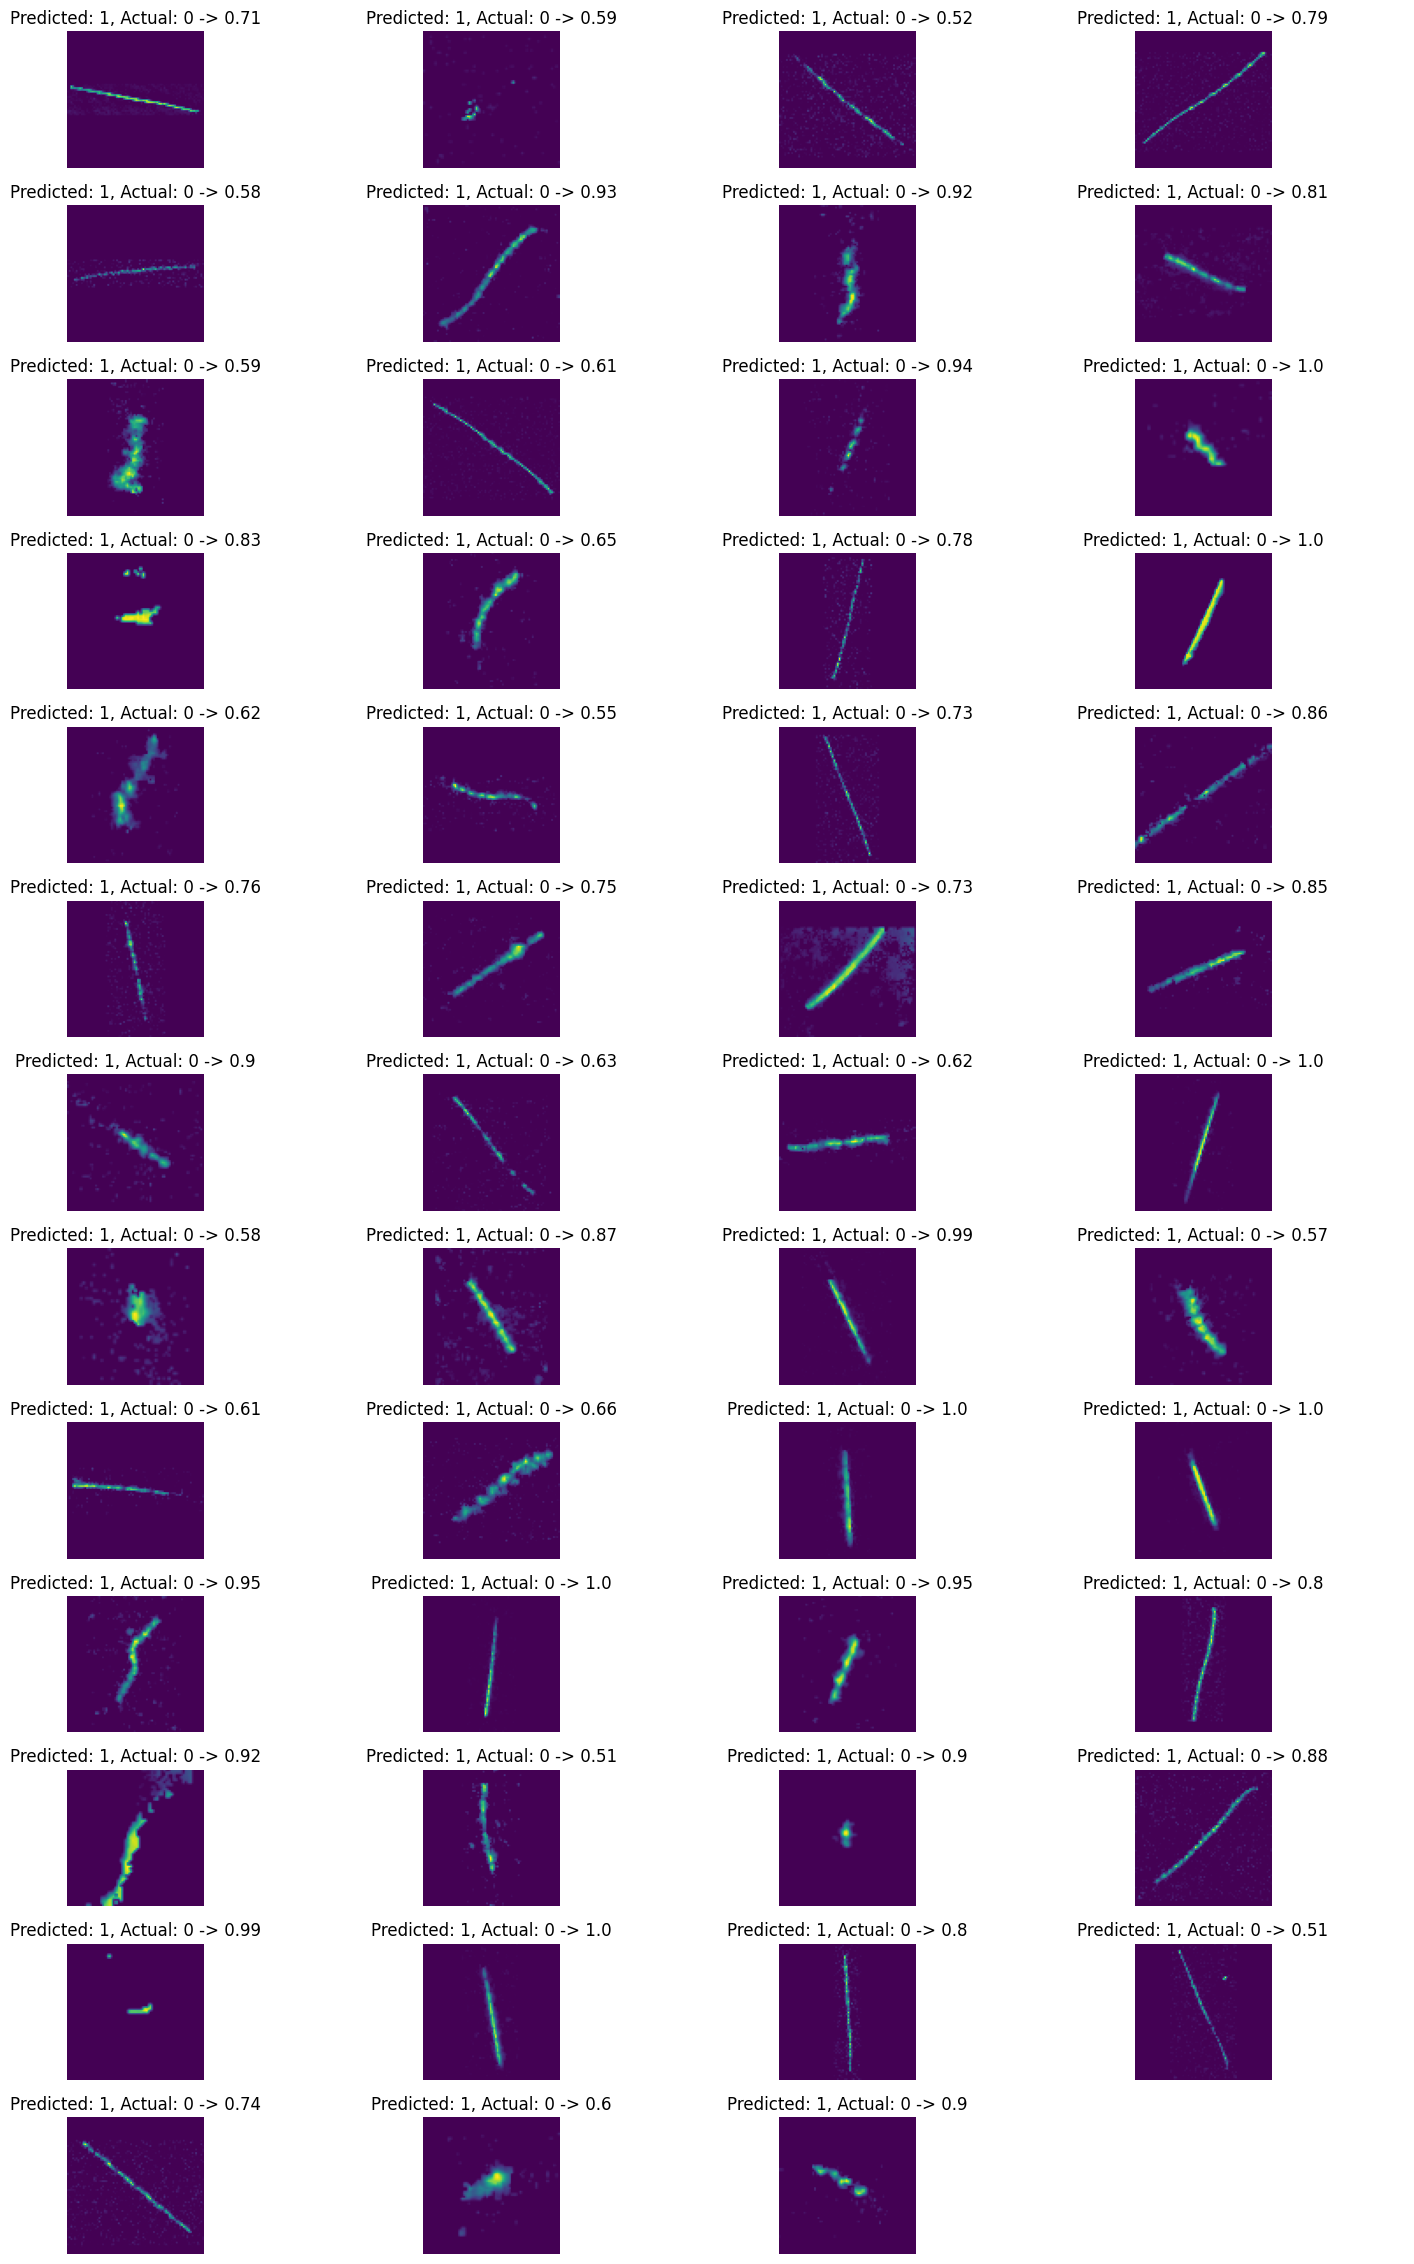

In [22]:
columns_num = 4
fig, axes = plt.subplots(
    math.ceil(false_negatives / columns_num),
    columns_num,
    figsize=(15, 7 * math.ceil(false_negatives / columns_num) / 4),
)
fig2, axes2 = plt.subplots(
    math.ceil(false_positives / columns_num),
    columns_num,
    figsize=(15, 7 * math.ceil(false_positives / columns_num) / 4),
)
for ax in axes.flatten():
    ax.axis("off")
for ax in axes2.flatten():
    ax.axis("off")

plt.subplots_adjust(hspace=0.05)
counter = 0
counter2 = 0
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter // columns_num
        col = counter % columns_num
        counter += 1
        prediction_confidence = str(round(prediction[0][0], 2))

        if math.ceil(false_negatives / columns_num) > 1:
            axes[row, col].imshow(img)
            axes[row, col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )
        else:
            axes[col].imshow(img)
            axes[col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )

    elif Y_pred_labels[i] == 1 and true_label == 0:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter2 // columns_num
        col = counter2 % columns_num
        counter2 += 1
        axes2[row, col].imshow(img)
        prediction_confidence = str(round(prediction[0][0], 2))
        axes2[row, col].set_title(
            f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
        )
print("False negatives:", counter)
print("False positives:", counter2)
plt.tight_layout()
plt.show()

### Prediction distribution

In [23]:
# Indices of meteors and artifacts in the actual labels
meteor_indices = np.where(Y_true == 1)[0]
artifact_indices = np.where(Y_true == 0)[0]

# Predictions for meteors and artifacts based on the actual labels
Y_pred_meteors = np.squeeze(Y_pred[meteor_indices])
Y_pred_artifacts = np.squeeze(Y_pred[artifact_indices])

Optimal Threshold: 0.5
Max F-beta Score: 0.9873949579831933


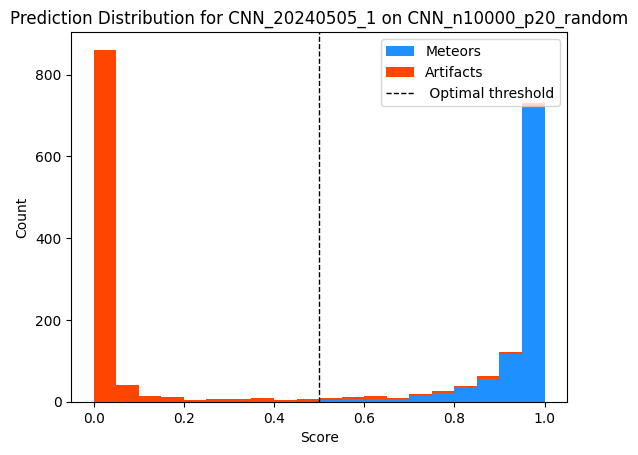

In [30]:
from sklearn.metrics import fbeta_score

# Define the beta value
beta = 2

# Define a range of thresholds to evaluate
thresholds = []
for i in range(5, 95, 5):
    thresholds.append(i / 100)


# Function to compute F-beta score for each threshold
def get_fbeta_score(y_true, y_probs, beta, threshold):
    y_pred = (y_probs >= threshold).astype(int)
    return fbeta_score(y_true, y_pred, beta=beta)


# Evaluate the F-beta score for each threshold
fbeta_scores = [
    get_fbeta_score(Y_true, Y_pred, beta, threshold) for threshold in thresholds
]

# Find the threshold that maximizes the F-beta score
optimal_threshold = thresholds[np.argmax(fbeta_scores)]
max_fbeta_score = max(fbeta_scores)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Max F-beta Score: {max_fbeta_score}")

plt.hist(
    [Y_pred_meteors, Y_pred_artifacts],
    label=["Meteors", "Artifacts"],
    stacked=False,
    histtype="barstacked",
    color=["dodgerblue", "orangered"],
    bins=20,
)
plt.axvline(
    optimal_threshold, color="k", linestyle="dashed", linewidth=1, label=" Optimal threshold"
)


plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"Prediction Distribution for {model._name} on {dataset_name}")
plt.legend()
#plt.savefig(f"models/{model._name}_prediction_distribution.png")
plt.show()

### Predicting single example

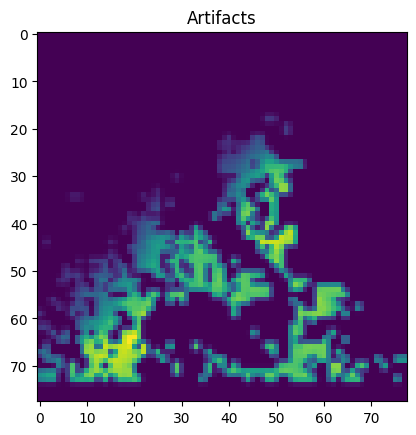

1/1 [==============================] - 0s 100ms/step
Prediction:           0.013519035652279854 - > True


In [31]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

## TFLite conversion

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f"models/{model._name}.tflite", "wb") as f:
    f.write(tflite_model)

## Testing Fiachra's model


In [33]:
interpreter = tf.lite.Interpreter(model_path="models/tflite/meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

resize_32 = layers.Resizing(32, 32)

# Initialize counters
TP = 0
FP = 0
FN = 0
total_predictions = 0

# Iterate over each batch
sample = val_ds.shuffle(1000)
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]

    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])

        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])

        # Get the highest scoring class
        prediction = int(np.round(output_data)[0][0])

        actual = label_batch[i].numpy()
        if prediction == 1:
            if actual == 1:
                TP += 1
            else:
                FP += 1
        elif actual == 1:
            FN += 1

# Calculate precision, recall, and F-beta score
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
beta = 2
fbeta_score = (
    (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    if precision > 0 and recall > 0
    else 0
)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-beta2 score: {fbeta_score}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Precision: 0.592814371257485
Recall: 1.0
F-beta2 score: 0.8792184724689165
